# Week 8 Problem 4

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select *Kernel*, and restart the kernel and run all cells (*Restart & Run all*).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select *File* → *Save and CheckPoint*)

5. When you are ready to submit your assignment, go to *Dashboard* → *Assignments* and click the *Submit* button. Your work is not submitted until you click *Submit*.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

## Author: Radhir Kothuri
### Primary Reviewer: Kelechi Ikegwu

# Due Date: 6 PM, March 12, 2018

In [1]:
% matplotlib inline
import matplotlib as mpl
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.testing import assert_array_equal
from nose.tools import assert_equal, assert_true, assert_almost_equal, assert_is_instance, assert_is_not
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, FactorAnalysis, MiniBatchSparsePCA
# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")

# Define plot style
sns.set(style='white', font_scale=1.5, 
        rc={'xtick.major.size': 4.0, 'ytick.major.size': 4.0})

# Function to plot data in PCA components
def plot_digit_pca(x, y, idx, ax, llc, xlbl, ylbl):
    
    # Plot real data in specified dimensions
    ax.scatter(x[:-idx], y[:-idx], 
               color=sns.xkcd_rgb['denim blue'], marker='o', alpha=0.5, s=30, 
               label='Real Data')
    
    # Plot fake data in specified dimensions
    ax.scatter(x[-idx:], y[-idx:], 
               color=sns.xkcd_rgb['pale red'], marker='d', alpha=0.75, s=60, 
               label='Fake Data')

    # Decorate plot
    ax.legend(loc=llc, frameon=True)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    sns.despine(offset=10)

def add_fake_data(data, num_points):
    append_data = data
    for point in range(num_points):
        array = []
        for i in range(10):
            array.append(random.uniform(-0.4, 0.4))
        append_data = np.vstack([append_data, array])
    return append_data

## Diabetes Dataset
For this assignment we will be using the built-in dataset about diabetes and the respective information on individual diabetes cases. This dataset has 442 samples and a dimensionality size of 10. In this assignment, we will be using the various attributes and Logistic Regression in order to create a model that we will tune and improve using cross-validation. Throughout the assignment, we will be improving our model from one that is very naïve to a more complicated one that accounts for all the attributes in the given dataset. 

The following code below imports the dataset as a pandas dataframe and previews a few sample data points.

In [2]:
'''
NOTE: Make sure to load this data set before completing the assignment
'''
columns = "age sex bmi map tc ldl hdl tch ltg glu".split()
# Load in the dataset as a Pandas DataFrame
data = load_diabetes()
data_df = pd.DataFrame(data.data, columns=columns)
# Preview the first few lines
data_df.head()
data_df.describe()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


## Question 1

In this question, we will use PCA for anomaly detection in order to detect outliers. Create a PCA model that is scaled and return the corresponding `PCA` object and fitted data as a 2-tuple.

- Use the function parameter `n_components` for the argument `n_components` in the `PCA` constructor. Use `random_state=23` in call to constructor as well.
- Scale the `data` function parameter using the `scale` method from the `sklearn.preprocessing` library. This method is already imported for you from above.
- Fit and transform the object using the `PCA` object that you have created.
- Return the `PCA` object and the `fitted_data` as 2-tuple respectively.

In [3]:
def pca_anomaly_detection(n_components, data):
    '''    
    Use PCA in order to detect outliers in the dataset
    
    Parameters
    ----------
    n_components: An int
    data: A np.ndarray
    
    Returns
    -------
    A 2-tuple of the PCA object and the fitted_data
    type: (sklearn.decomposition.PCA, np.ndarray)
    '''
    # YOUR CODE HERE
    
    pca = PCA(n_components=n_components, random_state=23)
    data = pca.fit_transform(scale(data))
    
    return (pca, data)

In [4]:
fake_data = add_fake_data(data.data.copy(), 20)
pca, fitted_data = pca_anomaly_detection(2, fake_data)
assert_true(isinstance(pca, PCA))
assert_equal(pca.n_components, 2)
assert_equal(pca.random_state, 23)
assert_true(isinstance(fitted_data, np.ndarray))

fake_data_2 = add_fake_data(data.data.copy()[:200], 20)
pca, fitted_data = pca_anomaly_detection(2, fake_data_2)
assert_true(isinstance(pca, PCA))
assert_equal(pca.n_components, 2)
assert_equal(pca.random_state, 23)
assert_true(isinstance(fitted_data, np.ndarray))

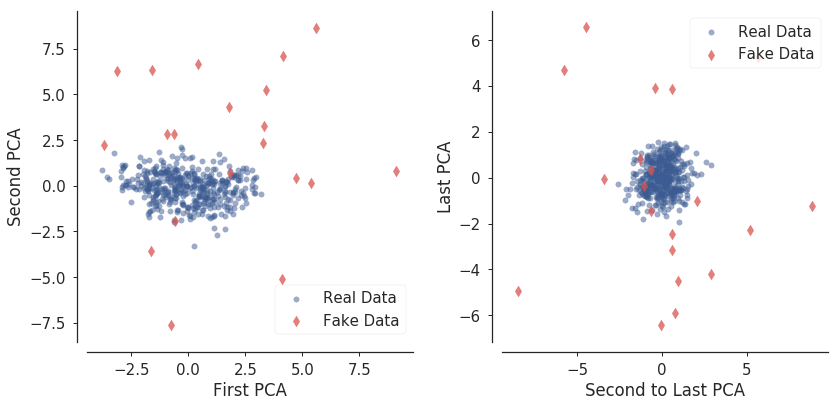

In [5]:
# Create figure
# Inject some fake data into the dataset
fake_data = add_fake_data(data.data.copy(), 20)
_, fitted_data = pca_anomaly_detection(4, fake_data)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot data in first two PCA components
plot_digit_pca(fitted_data[:, 0],fitted_data[:, 1], 20, axs[0], 4, 
               'First PCA', 'Second PCA')
# Plot data in last two PCA components
plot_digit_pca(fitted_data[:, -2], fitted_data[:, -1], 20, axs[1], 1, 
               'Second to Last PCA', 'Last PCA')
# Cleanup plot
plt.tight_layout()

As you can see from above, PCA when reduced from 10 components to 4 components performed adequately in differentiating the real data from the fake data. We will now look at another dimensionality reduction technique.

## Question 2

In this question, we will use another dimensionality reduction technique for anomaly detection in order to detect outliers - [`MiniBatchSparsePCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.MiniBatchSparsePCA.html). Create a MiniBatchSparsePCA model that is scaled and return the corresponding `MiniBatchSparsePCA` object and fitted data as a 2-tuple.

- Use the function parameter `n_components` for the argument `n_components` in the `MiniBatchSparsePCA` constructor. Use `random_state=23` in call to constructor as well.
- Scale the `data` function parameter using the `scale` method from the `sklearn.preprocessing` library. This method is already imported for you from above.
- Fit and transform the object using the `MiniBatchSparsePCA` object that you have created.
- Return the `MiniBatchSparsePCA` object and the `fitted_data` as 2-tuple respectively.

In [6]:
def minibatchsparsepca_anomaly_detection(n_components, data):
    '''    
    Use MiniBatchSparsePCA in order to detect outliers in the dataset
    
    Parameters
    ----------
    n_components: An int
    data: A np.ndarray
    
    Returns
    -------
    A 2-tuple of the MiniBatchSparsePCA object and the fitted_data
    type: (sklearn.decomposition.MiniBatchSparsePCA, np.ndarray)
    '''
    # YOUR CODE HERE
    
    model = MiniBatchSparsePCA(n_components=n_components, random_state=23)
    data = model.fit_transform(scale(data))
    
    return (model, data)
    

In [7]:
fake_data = add_fake_data(data.data.copy(), 20)
pca, fitted_data = minibatchsparsepca_anomaly_detection(2, fake_data)
assert_true(isinstance(pca, MiniBatchSparsePCA))
assert_equal(pca.n_components, 2)
assert_equal(pca.random_state, 23)
assert_true(isinstance(fitted_data, np.ndarray))

fake_data_2 = add_fake_data(data.data.copy()[:200], 20)
pca, fitted_data = minibatchsparsepca_anomaly_detection(4, fake_data_2)
assert_true(isinstance(pca, MiniBatchSparsePCA))
assert_equal(pca.n_components, 4)
assert_equal(pca.random_state, 23)
assert_true(isinstance(fitted_data, np.ndarray))

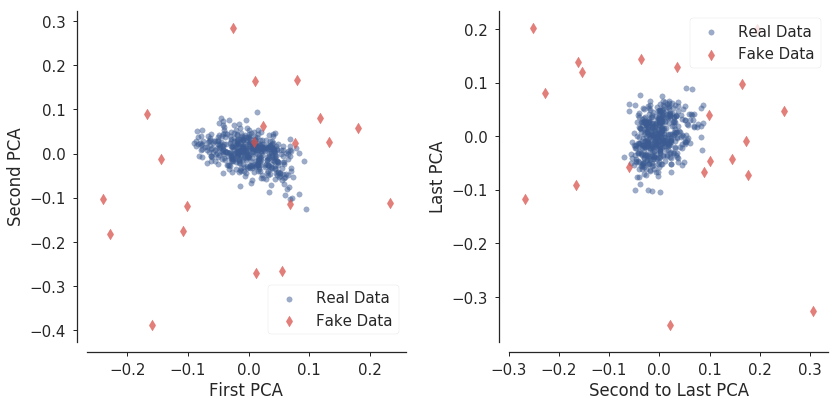

In [8]:
# Create figure
# Inject some fake data into the dataset
fake_data = add_fake_data(data.data.copy(), 20)
_, fitted_data = minibatchsparsepca_anomaly_detection(4, fake_data)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot data in first two PCA components
plot_digit_pca(fitted_data[:, 0],fitted_data[:, 1], 20, axs[0], 4, 
               'First PCA', 'Second PCA')
# Plot data in last two PCA components
plot_digit_pca(fitted_data[:, -2], fitted_data[:, -1], 20, axs[1], 1, 
               'Second to Last PCA', 'Last PCA')
# Cleanup plot
plt.tight_layout()

As you can see from above, MiniBatchSparsePCA when reduced from 10 components to 4 components performed adequately in differentiating the real data from the fake data. In fact, it performed even better than the regular PCA model as there is less fake data in the clusters of the real data.

## Question 3

In this question, we will use another dimensionality reduction technique for anomaly detection in order to detect outliers - [`FactorAnalysis`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html). Create a FactorAnalysis model that is scaled and return the corresponding `FactorAnalysis` object and fitted data as a 2-tuple.

- Use the function parameter `n_components` for the argument `n_components` in the `FactorAnalysis` constructor. Use `random_state=23` in call to constructor as well. Use `max_iter` function parameter in call to constructor too.
- Scale the `data` function parameter using the `scale` method from the `sklearn.preprocessing` library. This method is already imported for you from above.
- Fit and transform the object using the `FactorAnalysis` object that you have created.
- Return the `FactorAnalysis` object and the `fitted_data` as 2-tuple respectively.

In [9]:
def factoranalysis_anomaly_detection(n_components, data, max_iter):
    '''    
    Use FactorAnalysis in order to detect outliers in the dataset
    
    Parameters
    ----------
    n_components: An int
    data: A np.ndarray
    max_iter: An int
    
    Returns
    -------
    A 2-tuple of the FactorAnalysis object and the fitted_data
    type: (sklearn.decomposition.FactorAnalysis, np.ndarray)
    '''
    # YOUR CODE HERE
    
    model = FactorAnalysis(n_components=n_components, random_state=23, max_iter=max_iter)
    data = model.fit_transform(scale(data))
    
    return (model, data)
    

In [10]:
fake_data = add_fake_data(data.data.copy(), 20)
fa, fitted_data = factoranalysis_anomaly_detection(2, fake_data, 6)
assert_true(isinstance(fa, FactorAnalysis))
assert_equal(fa.n_components, 2)
assert_equal(fa.max_iter, 6)
assert_equal(fa.random_state, 23)
assert_true(isinstance(fitted_data, np.ndarray))

fake_data_2 = add_fake_data(data.data.copy()[:200], 20)
fa, fitted_data = factoranalysis_anomaly_detection(4, fake_data_2, 7)
assert_true(isinstance(fa, FactorAnalysis))
assert_equal(fa.n_components, 4)
assert_equal(fa.random_state, 23)
assert_equal(fa.max_iter, 7)
assert_true(isinstance(fitted_data, np.ndarray))

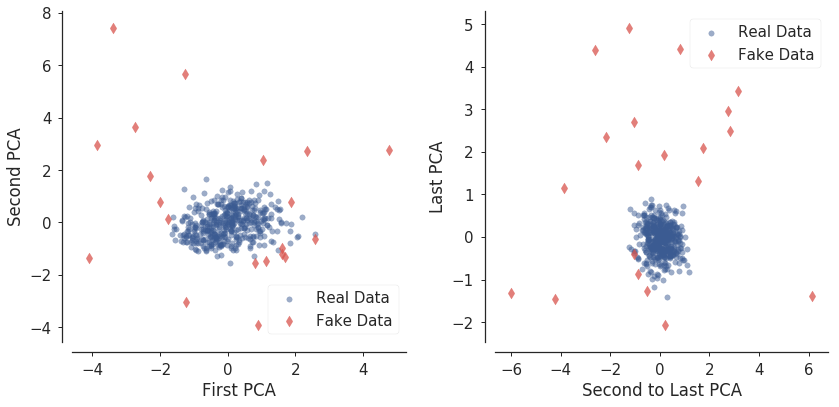

In [11]:
# Create figure
# Inject some fake data into the dataset
fake_data = add_fake_data(data.data.copy(), 20)
_, fitted_data = factoranalysis_anomaly_detection(4, fake_data, 6)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot data in first two PCA components
plot_digit_pca(fitted_data[:, 0],fitted_data[:, 1], 20, axs[0], 4, 
               'First PCA', 'Second PCA')
# Plot data in last two PCA components
plot_digit_pca(fitted_data[:, -2], fitted_data[:, -1], 20, axs[1], 1, 
               'Second to Last PCA', 'Last PCA')
# Cleanup plot
plt.tight_layout()